<img src="1.png" width="500">
<img src="2.png" width="500">
<img src="3.png" width="500">
<img src="4.png" width="500">
<img src="5.png" width="500">

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева.

---
---
---

Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Два класса будут сгенерированы из двух нормальных распределений с разными средними:

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Отобразим данные:

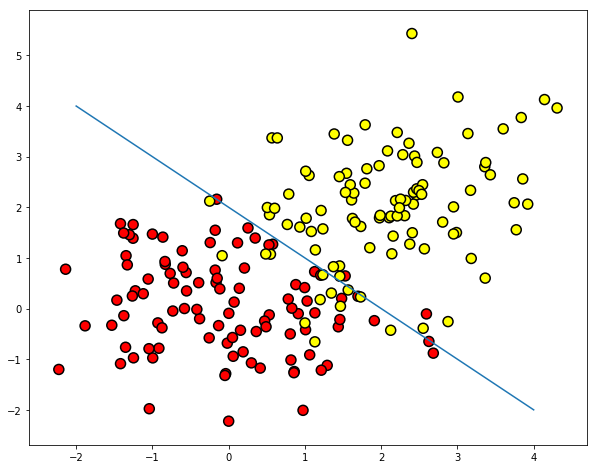

In [3]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(-2,5), range(4,-3,-1));
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
                                    cmap='autumn', edgecolors='black', linewidth=1.5);

Попробуем разделить эти два класса, обучив дерево решений:

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [5]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
clf_tree.fit(train_data, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

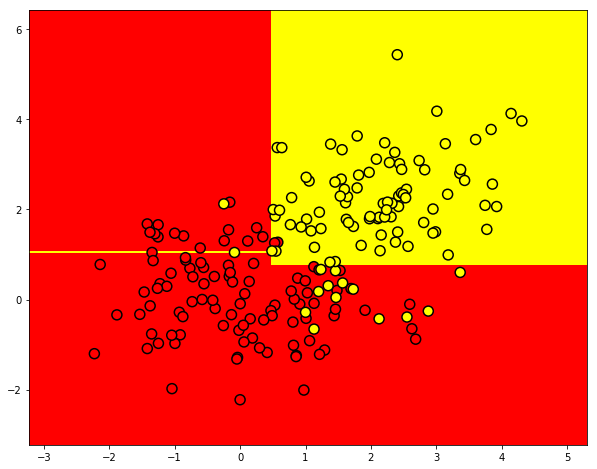

In [6]:
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
                                cmap='autumn', edgecolors='black', linewidth=1.5);

А как выглядит само построенное дерево?

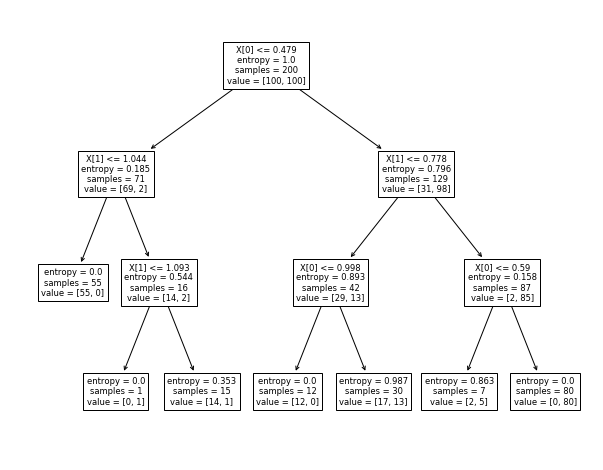

In [7]:
from sklearn import tree

tree.plot_tree(clf_tree);

Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x^2} + 1.5 e^{-(x-2)^2}$ c некоторым шумом, обучим на них дерево решений и изобразим:

In [8]:
def f(x):
    x = x.ravel()
    
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    
    return X, y

In [9]:
n_train = 150        
n_test = 1000       
noise = 0.1

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [10]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

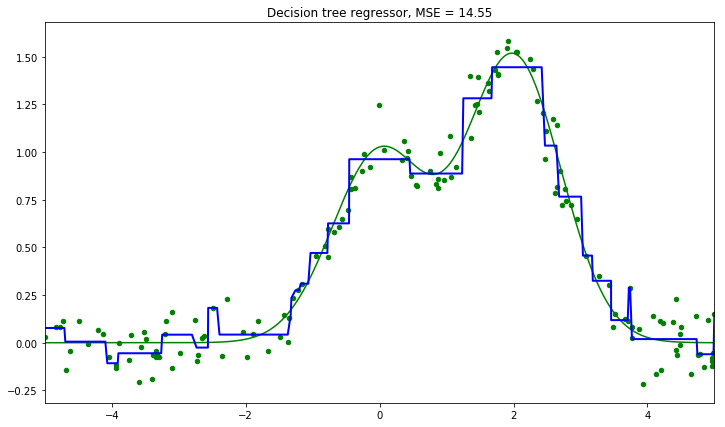

In [11]:
plt.figure(figsize=(12, 7))
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.xlim([-5, 5])

plt.plot(X_test, f(X_test), "g")
plt.scatter(X_train, y_train, c="g", s=20)
plt.plot(X_test, reg_tree_pred, "b", lw=2)

plt.show()

Видим, что дерево решений аппроксимирует зависимость в данных кусочно-постоянной функцией.

---
---
---

Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они:

In [12]:
df = pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [13]:
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')

states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


Выделим 70% выборки под обучение и 30% будут отложенной выборкой:

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [15]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3, random_state=17)

Обучим 2 модели – дерево решений и kNN:

In [16]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов:

In [17]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [18]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

Теперь настроим параметры дерева на кросс-валидации:

In [19]:
from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [20]:
tree_params = { 'max_depth': range(1,11), 'max_features': range(4,19) }
tree_grid = GridSearchCV( tree, tree_params, cv=5, n_jobs=-1, verbose=True )

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    4.5s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [21]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [22]:
tree_grid.best_score_

0.94257014456259

In [23]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

In [24]:
reg_tree = DecisionTreeRegressor(max_depth=6, max_features=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_holdout)

Теперь попробуем настроить число соседей в алгоритме kNN:

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
knn_pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('knn', KNeighborsClassifier(n_jobs=-1))
                    ])

knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV( knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True )

knn_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [27]:
knn_grid.best_params_

{'knn__n_neighbors': 7}

In [28]:
knn_grid.best_score_

0.8859867109023905

In [29]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

In [30]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)

        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
            
    return np.array(data), np.array(target)

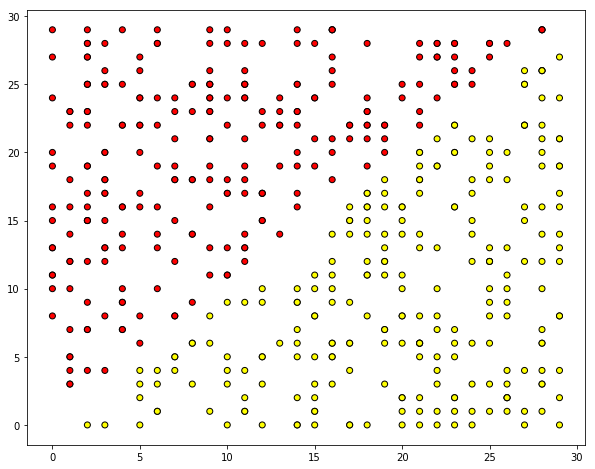

In [31]:
X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

In [32]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

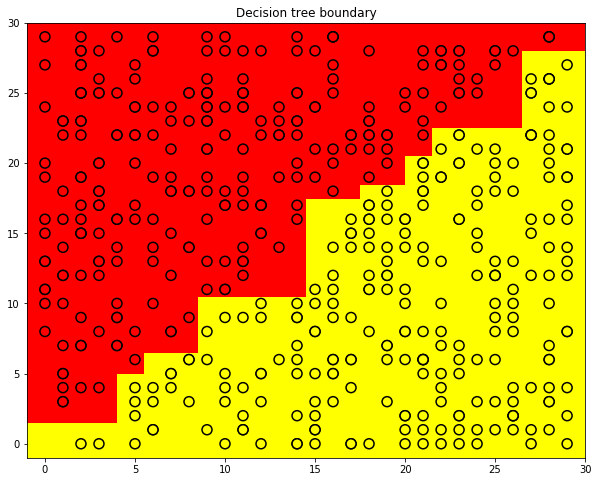

In [33]:
xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.title('Decision tree boundary')
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)

In [34]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

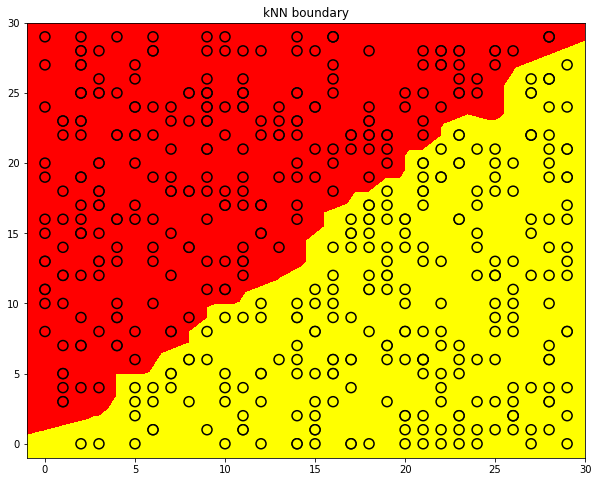

In [35]:
xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.title('kNN boundary')
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)

In [36]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)
    
    # первый признак пропорционален целевому
    x1 = 0.3 * y
    # остальные признаки – шум
    x_other = np.random.random(size=[n_obj, n_feat - 1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

In [37]:
X, y = form_noisy_data()

In [38]:
cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

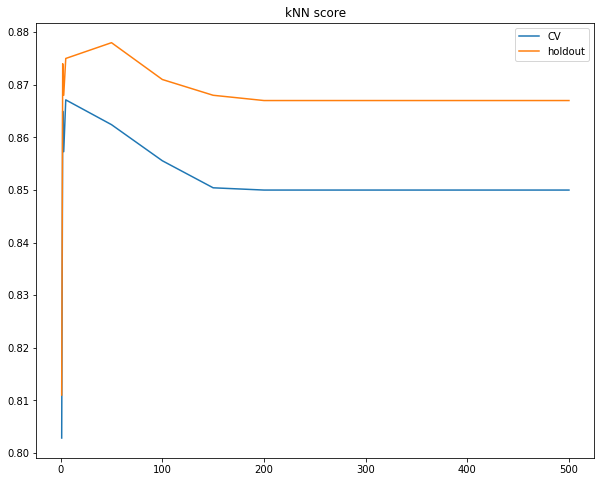

In [39]:
plt.title('kNN score')
plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')

plt.legend()

In [40]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))

tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))

print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 0.8636985231272574, holdout: 0.871
